# Predict tags on StackOverflow with linear models

### Text preprocessing

In [11]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/soumitra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [13]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [14]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [15]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
title    100000 non-null object
tags     100000 non-null object
dtypes: object(2)
memory usage: 1.5+ MB


As you can see, *title* column contains titles of the posts and *tags* column contains the tags. It could be noticed that a number of tags for a post is not fixed and could be as many as necessary.

For a more comfortable usage, initialize *X_train*, *X_val*, *X_test*, *y_train*, *y_val*.

In [17]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

In [18]:
X_train

array(['How to draw a stacked dotplot in R?',
       'mysql select all records where a datetime field is less than a specified value',
       'How to terminate windows phone 8.1 app', ...,
       'Python Pandas Series of Datetimes to Seconds Since the Epoch',
       'jqGrid issue grouping - Duplicate rows get appended every time sort is changed',
       'Create a List of primitive int?'], dtype=object)

One of the most known difficulties when working with natural data is that it's unstructured. For example, if you use it "as is" and extract tokens just by splitting the titles by whitespaces, you will see that there are many "weird" tokens like *3.5?*, *"Flip*, etc. To prevent the problems, it's usually useful to prepare the data somehow.


In [19]:
import re

In [20]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):

    text = text.lower()# lowercase text
    text = re.sub(REPLACE_BY_SPACE_RE," ",text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(BAD_SYMBOLS_RE,"",text)# delete symbols which are in BAD_SYMBOLS_RE from text
    text = " ".join([s for s in text.split(" ") if s not in STOPWORDS])# delete stopwords from text
    return text

In [21]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [22]:
print(test_text_prepare())

Wrong answer for the case: 'SQL Server - any equivalent of Excel's CHOOSE function?'


Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [23]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [24]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

For each tag and for each word calculate how many times they occur in the train corpus. 


In [25]:
y_train

array([list(['r']), list(['php', 'mysql']), list(['c#']), ...,
       list(['python', 'datetime', 'pandas']),
       list(['javascript', 'jquery']), list(['java', 'list', 'generics'])],
      dtype=object)

In [26]:
from nltk.tokenize.treebank import TreebankWordTokenizer
twd = TreebankWordTokenizer()
twd.tokenize(X_train[0])

['draw', 'stacked', 'dotplot', 'r']

In [27]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}

all_tags = []
vocabulary=[]
from collections import Counter
from nltk.tokenize.treebank import TreebankWordTokenizer
twd = TreebankWordTokenizer()

for tag in y_train:
    all_tags.extend(tag)

for txt in X_train:
    vocabulary.extend(twd.tokenize(txt))

tags_counts = Counter(all_tags)
words_counts = Counter(vocabulary)


We are assuming that *tags_counts* and *words_counts* are dictionaries like `{'some_word_or_tag': frequency}`. After applying the sorting procedure, results will be look like this: `[('most_popular_word_or_tag', frequency), ('less_popular_word_or_tag', frequency), ...]

### Transforming text to a vector

Machine Learning algorithms work with numeric data and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors. In this task you will try to use two of them.

#### Bag of words

One of the well-known approaches is a *bag-of-words* representation. To create this transformation, follow the steps:
1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Let's try to do it for a toy example. Imagine that we have *N* = 4 and the list of the most popular words is 

    ['hi', 'you', 'me', 'are']

Then we need to numerate them, for example, like this: 

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}

And we have the text, which we want to transform to the vector:

    'hi how are you'

For this text we create a corresponding zero vector 

    [0, 0, 0, 0]
    
And iterate over all words, and if the word is in the dictionary, we increase the value of the corresponding position in the vector:

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # word 'how' is not in our dictionary
    'are': [1, 0, 0, 1]
    'you': [1, 1, 0, 1]

The resulting vector will be 

    [1, 1, 0, 1]
   
Implement the described encoding in the function *my_bag_of_words* with the size of the dictionary equals to 5000. To find the most common words use train data. You can test your code using the function *test_my_bag_of_words*.

In [26]:
import operator

TOP_WORDS=sorted_d = sorted(words_counts.items(), key=operator.itemgetter(1),reverse=True)[:5000]

In [27]:
TOP_WORDS

[('using', 8278),
 ('c', 5800),
 ('php', 5614),
 ('java', 5501),
 ('file', 5055),
 ('javascript', 4746),
 ('#', 4522),
 ('error', 4390),
 ('get', 4301),
 ('python', 4073),
 ('string', 3655),
 ('array', 3535),
 ('data', 3298),
 ('jquery', 3293),
 ('value', 3176),
 ('function', 2896),
 ('object', 2654),
 ('class', 2558),
 ('use', 2422),
 ('c++', 2312),
 ('list', 2137),
 ('method', 2123),
 ('multiple', 2096),
 ('text', 1929),
 ('image', 1849),
 ('page', 1847),
 ('rails', 1778),
 ('form', 1776),
 ('create', 1760),
 ('html', 1716),
 ('type', 1699),
 ('code', 1664),
 ('set', 1640),
 ('working', 1636),
 ('database', 1631),
 ('add', 1611),
 ('convert', 1586),
 ('mysql', 1572),
 ('json', 1557),
 ('server', 1543),
 ('variable', 1542),
 ('android', 1530),
 ('values', 1528),
 ('aspnet', 1506),
 ('way', 1454),
 ('application', 1451),
 ('change', 1441),
 ('button', 1385),
 ('find', 1384),
 ('django', 1373),
 ('one', 1370),
 ('without', 1369),
 ('windows', 1339),
 ('not', 1314),
 ('can', 1314),
 ('ta

In [28]:
import operator
DICT_SIZE = 5000
ALL_WORDS =[i for i,j in sorted(words_counts.items(), key=operator.itemgetter(1),reverse=True)[:5000]]

WORDS_TO_INDEX = {}
for count, word in enumerate(ALL_WORDS):
    WORDS_TO_INDEX.update({word:count})
    
INDEX_TO_WORDS = dict((v,k) for k,v in WORDS_TO_INDEX.iteritems())
#ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):

    result_vector = np.zeros(dict_size)
    
    for word in text.split():
        if word in words_to_index.keys():
            x= words_to_index[word]
            result_vector[x]=1
    return result_vector

In [29]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [30]:
print(test_my_bag_of_words())

Basic tests are passed.


Now apply the implemented function to all samples (this might take up to a minute):

In [31]:
from scipy import sparse as sp_sparse

In [32]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

('X_train shape ', (100000, 5000))
('X_val shape ', (30000, 5000))
('X_test shape ', (20000, 5000))


As you might notice, we transform the data to sparse representation, to store the useful information efficiently. There are many [types](https://docs.scipy.org/doc/scipy/reference/sparse.html) of such representations, however sklearn algorithms can work only with [csr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix) matrix, so we will use this one.

In [34]:
X_train_mybag.shape

(100000, 5000)

In [35]:
row = X_train_mybag[10].toarray()[0]
row

array([0., 0., 0., ..., 0., 0., 0.])

In [36]:
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = len(row[row != 0])


#### TF-IDF

The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

Implement function *tfidf_features* using class [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from *scikit-learn*. Use *train* corpus to train a vectorizer. Don't forget to take a look into the arguments that you can pass to it. We suggest that you filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the titles). Also, use bigrams along with unigrams in your vocabulary. 

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [65]:
def tfidf_features(X_train, X_val, X_test):
   
    
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(token_pattern = '(\S+)') # we want c++ or c# to be there
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)

    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

Once you have done text preprocessing, always have a look at the results. Be very careful at this step, because the performance of future models will drastically depend on it. 

In this case, check whether you have c++ or c# in your vocabulary, as they are obviously important tokens in our tags prediction task:

In [66]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [67]:
X_val_tfidf

<30000x31497 sparse matrix of type '<type 'numpy.float64'>'
	with 161470 stored elements in Compressed Sparse Row format>

In [68]:
'c++' in tfidf_vocab # however we need to it,
 #Get back to the function above and use '(\S+)' regexp as a token_pattern 
#in the constructor of the vectorizer.

True

### MultiLabel classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [77]:
from sklearn.preprocessing import MultiLabelBinarizer

In [78]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

Implement the function *train_classifier* for training a classifier. In this task we suggest to use One-vs-Rest approach, which is implemented in [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) class. In this approach *k* classifiers (= number of tags) are trained. As a basic classifier, use [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because a number of classifiers to train is large.

In [79]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [80]:
def train_classifier(X_train, y_train):
    
    model = OneVsRestClassifier(LogisticRegression(random_state=0)).fit(X_train, y_train)
    
    return model
        

Train the classifiers for different data transformations: *bag-of-words* and *tf-idf*.

In [81]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

Now you can create predictions for the data. You will need two types of predictions: labels and scores.

In [82]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

Now take a look at how classifier, which uses TF-IDF, works for a few examples:

In [83]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	class


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails




Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure. 

### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 

In [84]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

Implement the function *print_evaluation_scores* which calculates and prints to stdout:
 - *accuracy*
 - *F1-score macro/micro/weighted*
 - *Precision macro/micro/weighted*

In [91]:
def print_evaluation_scores(y_val, predicted):
    
    print "Accuracy",accuracy_score(y_val, predicted)
    print "F1 Score",f1_score(y_val, predicted, average='macro')
    print "Average Precision",average_precision_score(y_val, predicted, average='macro') 
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################

In [92]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
Accuracy 0.3521666666666667
F1 Score 0.5060402133065638
Average Precision 0.34693305967002275
Tfidf
Accuracy 0.33626666666666666
F1 Score 0.4598657061568162
Average Precision 0.3115844561793255


You might also want to plot some generalization of the [ROC curve](http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for the case of multi-label classification. Provided function *roc_auc* can make it for you. The input parameters of this function are:
 - true labels
 - decision functions scores
 - number of classes

In [93]:
from metrics import roc_auc
%matplotlib inline

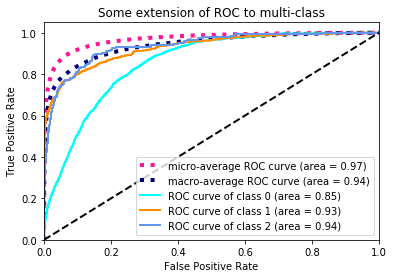

In [94]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

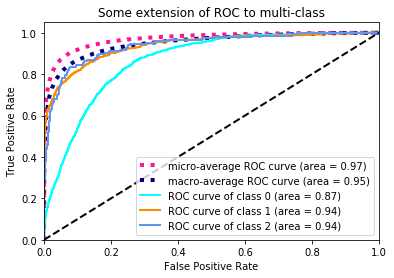

In [95]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)